In [1]:
import numpy as np
import pandas as pd

In [2]:
def read_data(fname):
    """ 
    Reads a CSV file into a pandas Dataframe, identifies and removes duplicate ones, and prints information
    about the shape of the data before and after duplicate removal.
    Parameter:
    -------
    fname: str
        The filename or path to the CSV file to be read.
    returns:
    -------
    pd.Dataframe
        The dataframe containing the data from the CSV file after removing duplication

    """
    df = pd.read_csv(fname)
    print("Data shape raw               : ", df.shape)
    num_duplicated = df.duplicated().sum()
    print("Number of duplicate order id : ",num_duplicated)
    df = df.drop_duplicates(keep='last')
    print("Data shape after dropping    : ", df.shape)
    print("Data shape final             : ", df.shape)
    return df

In [3]:
data = read_data(fname='./dataset/pd_loan_data_train.csv')

Data shape raw               :  (20400, 15)
Number of duplicate order id :  0
Data shape after dropping    :  (20400, 15)
Data shape final             :  (20400, 15)


In [4]:
def split_input_output(data,target_col):
    """
    Splits the dataset into training and testing sets for both features (X) and target (y) using stratified sampling.

    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        The feature set (input data) to be split.
    
    y : pd.Series or np.ndarray
        The target variable corresponding to the feature set.
    
    test_size : float
        The proportion of the dataset to include in the test split. 
        Should be between 0.0 and 1.0.
    
    seed : int
        The random seed for reproducibility of the split.
    
    Returns:
    --------
    tuple of pd.DataFrame/np.ndarray:
        - X_train : pd.DataFrame or np.ndarray
            The feature set for training.
        - X_test : pd.DataFrame or np.ndarray
            The feature set for testing.
        - y_train : pd.Series or np.ndarray
            The target variable for training.
        - y_test : pd.Series or np.ndarray
            The target variable for testing.
    
    Notes:
    ------
    - The function uses `train_test_split` from `sklearn.model_selection` to perform the split.
    - Stratified sampling is applied to ensure the target variable distribution is maintained between the training and test sets.
    """
    output_data = data[target_col]
    data = data.drop(target_col, axis = 1)
    print(f'X shape: {data.shape}')
    print(f'y shape: {output_data.shape}')
    return data, output_data

In [5]:
X, y = split_input_output(data=data, target_col='good_bad')

X shape: (20400, 14)
y shape: (20400,)


In [6]:
y.value_counts(normalize=True)

good_bad
1    0.857206
0    0.142794
Name: proportion, dtype: float64

EDA

In [7]:
100 * (X.isna().sum(0)/len(X))

loan_id                        0.000000
grade                          0.000000
home_ownership                 0.000000
purpose                        0.000000
verification_status            0.000000
term                           0.000000
emp_length_int                 0.000000
mths_since_issue_d             0.000000
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
acc_now_delinq                 6.647059
inq_last_6mths                 0.000000
annual_inc                     0.000000
dti                            0.000000
dtype: float64

In [8]:
data['acc_now_delinq'].value_counts(dropna=False)

acc_now_delinq
0.0    18969
NaN     1356
1.0       64
2.0       10
3.0        1
Name: count, dtype: int64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
cat = ['grade', 'home_ownership', 'purpose', 'verification_status', 'term']

In [11]:
pd.set_option('display.max_colwidth', None)

listItem = []
for col in data[cat]:
  listItem.append([col, data[col].nunique(), data[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

,nama kolom,jumlah nilai unique,nilai unique
0,grade,7,"[C, B, E, A, D, F, G]"
1,home_ownership,3,"[RENT, MORTGAGE, OWN]"
2,purpose,14,"[debt_consolidation, major_purchase, home_improvement, credit_card, medical, vacation, other, moving, small_business, house, wedding, car, educational, renewable_energy]"
3,verification_status,3,"[Verified, Source Verified, Not Verified]"
4,term,2,"[60 months, 36 months]"


In [12]:
def feature_engineering(df):
    import pandas as pd
    import numpy as np

    df = df.copy()  # Supaya gak ubah data aslinya

    # ============================
    # 1. Drop kolom tidak informatif
    # ============================
    if 'loan_id' in df.columns:
        df.drop('loan_id', axis=1, inplace=True)

    # ============================
    # 2. Rasio dan kombinasi numerik
    # ============================
    df['loan_to_income'] = df['int_rate'] / (df['annual_inc'] + 1)
    df['debt_burden'] = df['dti'] * df['int_rate']
    df['term'] = df['term'].str.replace(' months', '').astype(int)

    # ============================

    # ============================
    # 4. Transform fitur aneh
    # ============================
    if 'acc_now_delinq' in df.columns:
        df['has_delinquency'] = df['acc_now_delinq'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
        df.drop('acc_now_delinq', axis=1, inplace=True)

    # ============================
    # 5. Encoding kategori (kalau belum)
    # ============================
    # Biasanya dilakukan di pipeline lain

    # ============================
    # 6. Simplifikasi kategori purpose
    # ============================
    if 'purpose' in df.columns:
        main_purposes = ['debt_consolidation', 'credit_card', 'home_improvement',
                         'major_purchase', 'small_bussiness', 'car']
        df['purpose'] = df['purpose'].apply(
            lambda x: x if x in main_purposes else 'other'
        )
    # Menyatukan kategori minor ke dalam 'other'

    return df


In [13]:
X_feature_engineering = feature_engineering(X)

In [14]:
def split_cat_num_col(df:pd.DataFrame) -> tuple:
    """
    Splits categorical and numerical columns from a DataFrame.
    Boolean columns are treated as categorical.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple[pd.DataFrame, pd.DataFrame]: 
        - List of categorical columns (including boolean columns)
        - List of numerical columns
    """
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()

    return cat_cols, num_cols

In [15]:
cat_cols, num_cols = split_cat_num_col(X_feature_engineering)

In [16]:
cat_cols

['grade', 'home_ownership', 'purpose', 'verification_status']

In [17]:
X_feature_engineering.columns

Index(['grade', 'home_ownership', 'purpose', 'verification_status', 'term',
       'emp_length_int', 'mths_since_issue_d', 'int_rate',
       'mths_since_earliest_cr_line', 'inq_last_6mths', 'annual_inc', 'dti',
       'loan_to_income', 'debt_burden', 'has_delinquency'],
      dtype='object')

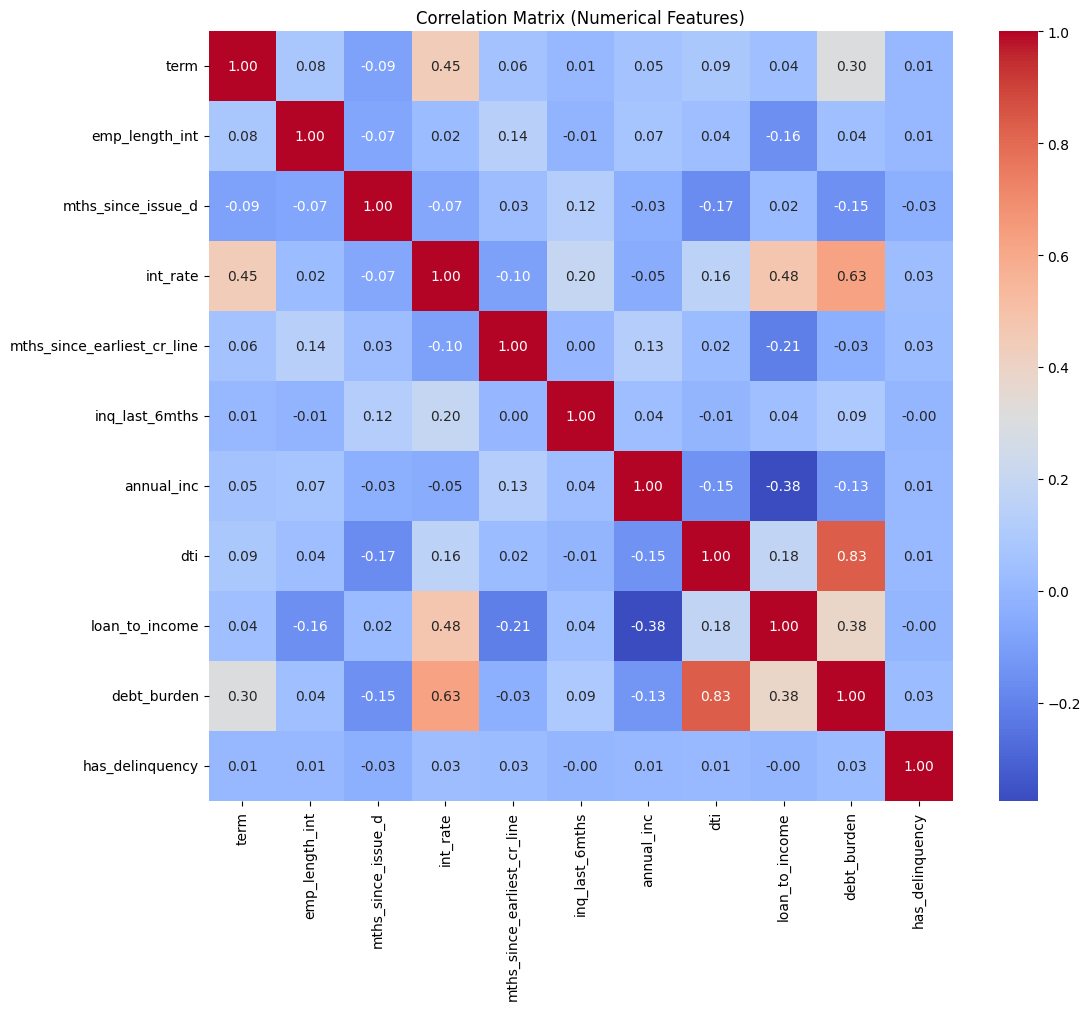

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya fitur numerik
plt.figure(figsize=(12, 10))
sns.heatmap(X_feature_engineering[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()


In [19]:
train_data = pd.concat([X_feature_engineering,y],axis=1)
train_data.head()

,grade,home_ownership,purpose,verification_status,term,emp_length_int,mths_since_issue_d,int_rate,mths_since_earliest_cr_line,inq_last_6mths,annual_inc,dti,loan_to_income,debt_burden,has_delinquency,good_bad
0,C,RENT,debt_consolidation,Verified,60,7,54,15.80,231,1,105000.0,7.56,0.000150,119.4480,0,1
1,B,RENT,debt_consolidation,Verified,36,2,47,9.67,145,0,54000.0,24.64,0.000179,238.2688,0,1
2,E,RENT,debt_consolidation,Verified,60,0,48,21.48,118,2,30000.0,17.76,0.000716,381.4848,0,1
3,A,RENT,debt_consolidation,Source Verified,36,10,71,7.90,216,0,35000.0,21.87,0.000226,172.7730,0,1
4,C,MORTGAGE,major_purchase,Source Verified,36,10,46,14.16,202,1,62570.0,12.54,0.000226,177.5664,0,1


In [20]:
idx_to_drop = train_data[
    (train_data['inq_last_6mths']>7) |
    (train_data['mths_since_earliest_cr_line']>500)
].index.tolist()

In [21]:
X_dropped = X.drop(index=idx_to_drop)
y_dropped = y.drop(index=idx_to_drop)

In [22]:
from sklearn.model_selection import train_test_split
def split_train_test(X,y,test_size, seed):
    """
    Splits the dataset into training and testing sets for both features (X) and target (y) using stratified sampling.

    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        The feature set (input data) to be split.
    
    y : pd.Series or np.ndarray
        The target variable corresponding to the feature set.
    
    test_size : float
        The proportion of the dataset to include in the test split. 
        Should be between 0.0 and 1.0.
    
    seed : int
        The random seed for reproducibility of the split.
    
    Returns:
    --------
    tuple of pd.DataFrame/np.ndarray:
        - X_train : pd.DataFrame or np.ndarray
            The feature set for training.
        - X_test : pd.DataFrame or np.ndarray
            The feature set for testing.
        - y_train : pd.Series or np.ndarray
            The target variable for training.
        - y_test : pd.Series or np.ndarray
            The target variable for testing.
    
    Notes:
    ------
    - The function uses `train_test_split` from `sklearn.model_selection` to perform the split.
    - Stratified sampling is applied to ensure the target variable distribution is maintained between the training and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,stratify=y)
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')
    
    return X_train, X_test, y_train, y_test

In [23]:
X_train_dropped, X_valid_dropped, y_train_dropped, y_valid_dropped = split_train_test(X=X_feature_engineering,y=y, test_size=0.2, seed=123)

X_train shape: (16320, 15)
X_test shape: (4080, 15)
y_train shape: (16320,)
y_test shape: (4080,)


In [24]:
cat_cols

['grade', 'home_ownership', 'purpose', 'verification_status']

In [25]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Inisialisasi list untuk hasil
p_values = []
interpretasi = []
colss = ['home_ownership', 'purpose', 'verification_status']   # Daftar nama kolom kategorikal

# Loop untuk menghitung p-value chi2 untuk setiap kolom kategorikal
for col in colss:
    # Encoding kategorikal ke numerik
    le = LabelEncoder()
    X_encoded = le.fit_transform(X_train_dropped[col])  # Mengubah menjadi array numerik

    # Menghitung chi2
    chi2_stat, p_value = chi2(X_encoded.reshape(-1, 1), y_train_dropped)  # Melakukan uji chi2

    # Menyimpan hasil
    p_values.append(p_value[0])  # Chi2 mengembalikan array, kita ambil nilai pertama
    if p_value[0] < 0.05:  # Bandingkan nilai pertama p-value
        interpretasi.append('ada korelasi')
    else:
        interpretasi.append('ga ada korelasi')

# Menampilkan hasil seleksi fitur
hasil = pd.DataFrame({'nama kolom': colss, 'p-value': p_values, 'hasil': interpretasi})
print(hasil)

            nama kolom       p-value         hasil
0       home_ownership  2.234889e-14  ada korelasi
1              purpose  5.913392e-07  ada korelasi
2  verification_status  1.744884e-07  ada korelasi


In [26]:
X_train_dropped.columns

Index(['grade', 'home_ownership', 'purpose', 'verification_status', 'term',
       'emp_length_int', 'mths_since_issue_d', 'int_rate',
       'mths_since_earliest_cr_line', 'inq_last_6mths', 'annual_inc', 'dti',
       'loan_to_income', 'debt_burden', 'has_delinquency'],
      dtype='object')

In [27]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
import pandas as pd

# Definisi kolom dan urutan kategori ordinalnya
cat_ord = ['grade']
ordinal_mapping = {
    'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']
}

# Encoder: pakai urutan kategori sesuai definisi
encoder = OrdinalEncoder(categories=[ordinal_mapping[col] for col in cat_ord])
X_encoded = encoder.fit_transform(X_train_dropped[cat_ord])

# Chi-square test
chi2_stat, p_values = chi2(X_encoded, y_train_dropped)

# Interpretasi hasil
interpretasi = ['ada korelasi' if p < 0.05 else 'ga ada korelasi' for p in p_values]
hasil = pd.DataFrame({
    'nama kolom': cat_ord,
    'p-value': p_values,
    'hasil': interpretasi
})

print(hasil)


  nama kolom        p-value         hasil
0      grade  2.222375e-131  ada korelasi


In [28]:
from scipy.stats import kendalltau
import pandas as pd
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []

for col in num_cols:
  corr_coef, p_value = kendalltau(X_train_dropped[col], y_train_dropped)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi,
              'P_value': p_values})

,nama kolom,hasil,P_value
0,term,ada korelasi,1.755893e-20
1,emp_length_int,ada korelasi,3.551128e-06
2,mths_since_issue_d,ada korelasi,5.356451e-37
3,int_rate,ada korelasi,1.327502e-128
4,mths_since_earliest_cr_line,ada korelasi,2.411730e-04
5,inq_last_6mths,ada korelasi,2.893021e-32
6,annual_inc,ada korelasi,1.482190e-16
7,dti,ada korelasi,9.428974e-15
8,loan_to_income,ada korelasi,1.885840e-85
9,debt_burden,ada korelasi,1.754422e-74


In [29]:
y_train_dropped.value_counts(normalize=True)

good_bad
1    0.85723
0    0.14277
Name: proportion, dtype: float64

In [30]:
from sklearn.impute import SimpleImputer
def num_imputer_fit(data):
    ''' 
    Fit a SimpleImputer to the numerical data using the median strategy.

    Parameters

    data : pandas.DataFrame
    DataFrame containing numerical data with missing values (np.nan).

    Returns

    SimpleImputer
    A fitted SimpleImputer object configured to use the median strategy for imputation.
    '''
    imputer = SimpleImputer(strategy='median')
    imputer.fit(data)
    return imputer
def num_imputer_transform(data, imputer):
    ''' 
    Transform the numerical data using a fitted SimpleImputer.

    Parameters

    data : pandas.DataFrame
    DataFrame containing numerical data to be imputed.

    imputer : SimpleImputer
    A fitted SimpleImputer object that will be used to perform the imputation.

    Returns

    pandas.DataFrame
    DataFrame containing the imputed numerical data, with the same columns and index as the input data.
    '''
    imputed_data = imputer.transform(data)
    imputed_data_df = pd.DataFrame(imputed_data, columns=data.columns, index=data.index)
    return imputed_data_df

In [31]:
X_train_num = X_train_dropped[num_cols]
X_train_cat = X_train_dropped[cat_cols]

In [32]:
X_train_num.isna().sum(0)

term                           0
emp_length_int                 0
mths_since_issue_d             0
int_rate                       0
mths_since_earliest_cr_line    0
inq_last_6mths                 0
annual_inc                     0
dti                            0
loan_to_income                 0
debt_burden                    0
has_delinquency                0
dtype: int64

In [33]:
num_imputer = num_imputer_fit(X_train_num)
X_train_num_imputed = num_imputer_transform(X_train_num, num_imputer)

In [34]:
from sklearn.preprocessing import OneHotEncoder
def cat_OHE_encoder_fit(data):
    ''' 
    Fit a OneHotEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    Returns

    OneHotEncoder
    A fitted OneHotEncoder object, which can be used to transform the data
    '''
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data)
    return encoder

def cat_OHE_encoder_transform(data, encoder):
    ''' 
    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    encoder : OneHotEncoder
    A fitted OneHotEncoder object used to encode the data.

    Returns

    pandas.DataFrame
    '''
    encoded_array = encoder.transform(data)
    feature_names = encoder.get_feature_names_out()
    cleaned_columns = [col.split('_')[-1] for col in feature_names]
    encoded_data = pd.DataFrame(encoded_array, columns=cleaned_columns, index=data.index)
    return encoded_data

In [35]:
from sklearn.preprocessing import OrdinalEncoder

def cat_ordinal_encoder_fit(data, categories):
    ''' 
    Fit an OrdinalEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
        DataFrame containing a single column of categorical data to be encoded.

    categories : list of lists
        A list of lists specifying the categories for each feature. Each inner list corresponds to a feature and contains the categories in the order they should be encoded.

    Returns

    OrdinalEncoder
        A fitted OrdinalEncoder object that can be used to transform the data.
    '''
    encoder = OrdinalEncoder(categories=categories)
    encoder.fit(data)
    return encoder

def cat_ordinal_encoder_transform(data, encoder):
    '''  
    Transform the categorical data using a fitted OrdinalEncoder.

    Parameters

    data : pandas.DataFrame
        DataFrame containing a single column of categorical data to be encoded.

    encoder : OrdinalEncoder
        A fitted OrdinalEncoder object used to encode the data.

    Returns

    pandas.DataFrame
        DataFrame containing the encoded data, with the same index as the input data.
    '''
    encoded_array = encoder.transform(data)
    encoded_data = pd.DataFrame(encoded_array, columns=data.columns, index=data.index)

    return encoded_data

In [36]:
for col in X_train_cat.columns:
    print(X_train_cat[col].unique(),col)

['B' 'D' 'A' 'F' 'C' 'E' 'G'] grade
['OWN' 'MORTGAGE' 'RENT'] home_ownership
['credit_card' 'debt_consolidation' 'car' 'home_improvement' 'other'
 'major_purchase'] purpose
['Verified' 'Not Verified' 'Source Verified'] verification_status


In [37]:
# Fitur dengan OneHotEncoding
ohe_features = ['home_ownership', 'purpose', 'verification_status']

# Fitur ordinal dengan urutan kategori yang jelas
ordinal_features = {
    'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']
}


In [38]:
# OneHotEncoder
cat_ohe_encoder = cat_OHE_encoder_fit(X_train_cat[ohe_features])

# OrdinalEncoder
cat_ordinal_encoder = cat_ordinal_encoder_fit(
    data=X_train_cat[list(ordinal_features.keys())],
    categories=list(ordinal_features.values())
)


In [39]:
# Encode OHE features
X_train_cat_ohe_encoded = cat_OHE_encoder_transform(X_train_cat[ohe_features], cat_ohe_encoder)

# Encode ordinal features
X_train_cat_ordinal_encoded = cat_ordinal_encoder_transform(
    X_train_cat[list(ordinal_features.keys())],
    cat_ordinal_encoder
)


In [40]:
X_train_cat_encoded_concat = pd.concat([X_train_cat_ohe_encoded, X_train_cat_ordinal_encoded], axis=1)


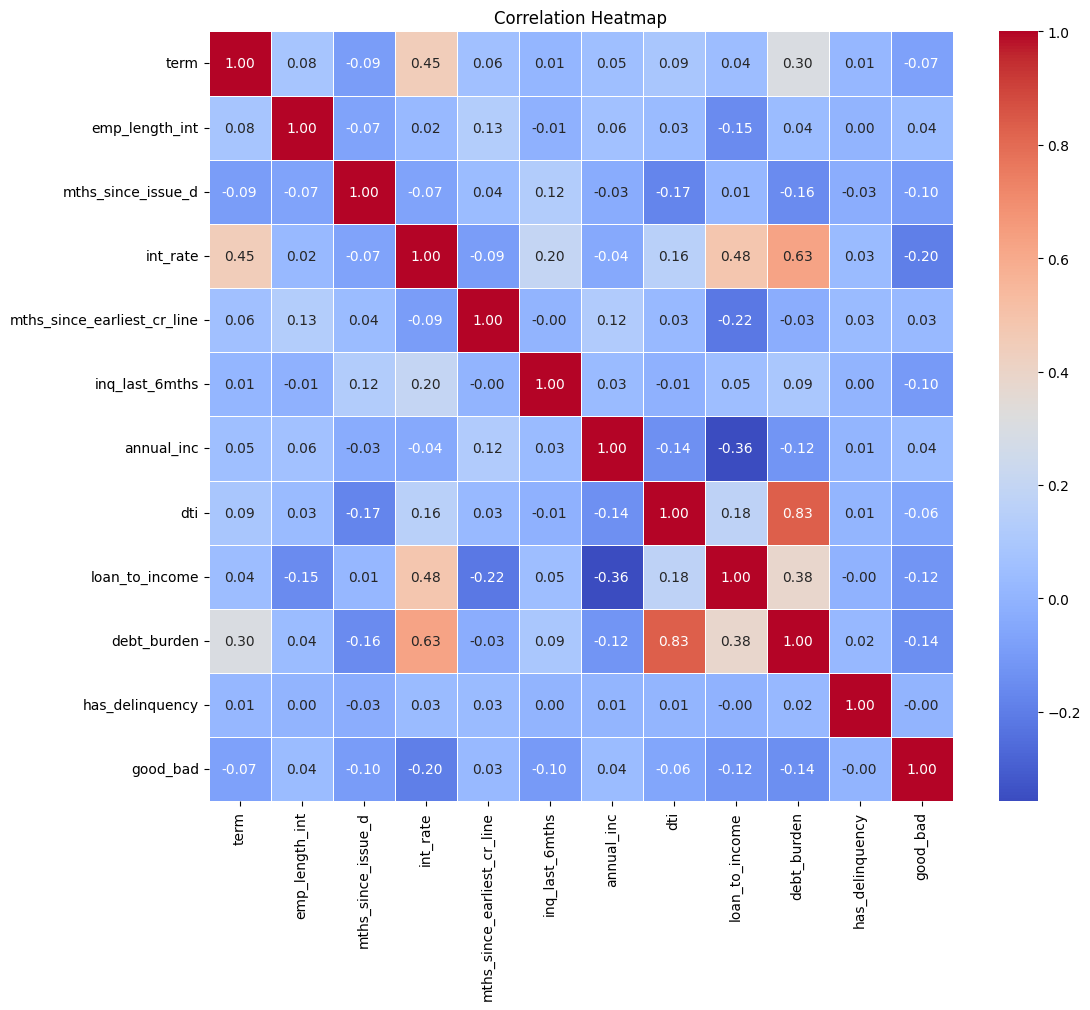

In [41]:
data_for_correlation = pd.concat([X_train_num_imputed, y_train_dropped], axis=1)


correlation_matrix_X_train_num = data_for_correlation.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_X_train_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [42]:
from sklearn.preprocessing import StandardScaler
def fit_scaler(data):
    '''  
    Fits a StandardScaler to the numerical data.

    This function computes the mean and standard deviation for each feature in the data to standardize them.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.

    Returns:
    scaler (StandardScaler): A fitted StandardScaler object that can be used to transform the data.
    '''
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler
def transform_scaler(data, scaler):
    '''  
    Transforms the numerical data using a fitted StandardScaler.

    This function scales the data based on the mean and standard deviation computed by the fitted StandardScaler.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.
    scaler (StandardScaler): A fitted StandardScaler object used for scaling the data.

    Returns:
    scaled_data (pd.DataFrame): DataFrame containing the scaled numerical data.
    '''
    scaled_array = scaler.transform(data)
    scaled_data = pd.DataFrame(scaled_array, index=data.index, columns=data.columns)
    return scaled_data

In [43]:
scaler = fit_scaler(X_train_num_imputed)
X_train_num_scale = transform_scaler(X_train_num_imputed, scaler)

In [44]:
def concat_data(num_data, cat_data):
    '''  
    Concatenates numerical and categorical data into a single DataFrame.

    This function ensures that the indices of the numerical and categorical data match before concatenation. If the indices do not match, the categorical data is reindexed to match the numerical data.

    Parameters:
    - num_data (pd.DataFrame): DataFrame containing numerical data.
    - cat_data (pd.DataFrame): DataFrame containing categorical data.

    Returns:
    - concatenated_data (pd.DataFrame): DataFrame with both numerical and categorical data concatenated along columns.
    '''
    if not num_data.index.equals(cat_data.index):
        cat_data = cat_data.reindex(num_data.index)
    concatenated_data = pd.concat([num_data, cat_data], axis=1)
    print(f'Numerical data shape  : {num_data.shape}')
    print(f'Categorical data shape: {cat_data.shape}')
    print(f'Concat data shape     : {concatenated_data.shape}')
    return concatenated_data

In [45]:
X_train_concat = concat_data(X_train_num_scale,X_train_cat_encoded_concat)

Numerical data shape  : (16320, 11)
Categorical data shape: (16320, 13)
Concat data shape     : (16320, 24)


In [46]:
def preprocess_data(data, num_cols, cat_cols, ohe_feat, ordinal_feat_dict, 
                    num_imputer, cat_ohe_encoder, cat_ordinal_encoder, scaler):
    """
    Preprocess the dataset by handling numerical, one-hot, and ordinal categorical data.

    Parameters:
    - data: DataFrame, full input dataset
    - num_cols: list, numerical column names
    - cat_cols: list, all categorical column names
    - ohe_feat: list, names of categorical features for one-hot encoding
    - ordinal_feat_dict: dict, keys = ordinal column names, values = list of ordered categories
    - num_imputer: fitted numerical imputer
    - cat_ohe_encoder: fitted OneHotEncoder
    - cat_ordinal_encoder: fitted OrdinalEncoder (must match order in ordinal_feat_dict)
    - scaler: fitted numerical scaler

    Returns:
    - clean_data: DataFrame, fully preprocessed and concatenated data
    """
    # Split data
    num_data = data[num_cols]
    cat_data = data[cat_cols]
    ohe_data = cat_data[ohe_feat]
    ordinal_data = cat_data[list(ordinal_feat_dict.keys())]

    # Transform
    num_data_imputed = num_imputer_transform(num_data, num_imputer)
    num_data_scaled = transform_scaler(num_data_imputed, scaler)
    
    cat_ohe_data_encoded = cat_OHE_encoder_transform(ohe_data, cat_ohe_encoder)
    cat_ordinal_data_encoded = cat_ordinal_encoder_transform(ordinal_data, cat_ordinal_encoder)

    # Concatenate
    cat_data_concat = pd.concat([cat_ohe_data_encoded, cat_ordinal_data_encoded], axis=1)
    clean_data = concat_data(num_data_scaled, cat_data_concat)

    print(f'Mapped data shape  : {clean_data.shape}')
    return clean_data


In [47]:
# OHE features
ohe_feat = ['home_ownership', 'purpose', 'verification_status']

# Semua ordinal features
ordinal_feat = {
    'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']
}

# Jalankan preprocessing
X_train_clean = preprocess_data(
    data=X_train_dropped,
    num_cols=num_cols,
    cat_cols=cat_cols,
    ohe_feat=ohe_feat,
    ordinal_feat_dict=ordinal_feat,
    num_imputer=num_imputer,
    cat_ohe_encoder=cat_ohe_encoder,
    cat_ordinal_encoder=cat_ordinal_encoder,
    scaler=scaler
)


Numerical data shape  : (16320, 11)
Categorical data shape: (16320, 13)
Concat data shape     : (16320, 24)
Mapped data shape  : (16320, 24)


In [48]:
X_valid_clean = preprocess_data(
    data=X_valid_dropped, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ohe_feat=ohe_feat, 
    ordinal_feat_dict=ordinal_feat,  # ← gunakan dict lengkap
    num_imputer=num_imputer,
    cat_ohe_encoder=cat_ohe_encoder,
    cat_ordinal_encoder=cat_ordinal_encoder,
    scaler=scaler
)


Numerical data shape  : (4080, 11)
Categorical data shape: (4080, 13)
Concat data shape     : (4080, 24)
Mapped data shape  : (4080, 24)


In [49]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_train_clean, y_train_dropped)

In [50]:

def extract_cv_results(cv_obj):
    '''  
    Extracts the best scores and parameters from a cross-validation object.

    Parameters:
    cv_obj (GridSearchCV or RandomizedSearchCV): The fitted cross-validation object.

    Returns:
    best_train_score (float): The mean training score of the best model.
    best_valid_score (float): The best validation score.
    best_params (dict): The hyperparameters of the best model.
    '''

    best_train_score = cv_obj.cv_results_['mean_train_score'][cv_obj.best_index_]

    best_valid_score = cv_obj.best_score_  
    
    best_params = cv_obj.best_params_
    
    return best_train_score, best_valid_score, best_params


In [51]:
from sklearn.model_selection import StratifiedKFold

stratified_cv = StratifiedKFold(n_splits=5)

In [52]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

param_grid_base = {'strategy': ['stratified']}
baseline_model = DummyClassifier()
reg_base = GridSearchCV(baseline_model, param_grid_base, scoring='f1_macro', return_train_score=True)
reg_base.fit(X_train_clean, y_train_dropped)


GridSearchCV(estimator=DummyClassifier(),
             param_grid={'strategy': ['stratified']}, return_train_score=True,
             scoring='f1_macro')

In [53]:
train_base, valid_base, best_param_base = extract_cv_results(reg_base)

print(f'Train score - Baseline model: {train_base}')
print(f'Valid score - Baseline model: {valid_base}')
print(f'Best Params - Baseline model: {best_param_base}')

Train score - Baseline model: 0.5010059604885099
Valid score - Baseline model: 0.5015132604738537
Best Params - Baseline model: {'strategy': 'stratified'}


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# F1 scorer
f1_scorer = make_scorer(f1_score)

# Parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],         # regularisasi
    'penalty': ['l2'],               # l1 kalau pakai solver='liblinear'
    'solver': ['lbfgs'],             # untuk L2 penalty, 'liblinear' juga bisa
    'max_iter': [100, 200, 300]
}

# Inisialisasi Logistic Regression dengan class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced')

# GridSearchCV pakai f1_score untuk penilaian model
clas_lr = GridSearchCV(lr_model, param_grid_lr, scoring='f1_macro', return_train_score=True)

# Fit model ke data training
clas_lr.fit(X_train_clean, y_train_dropped)


GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             return_train_score=True, scoring='f1_macro')

In [55]:
train_lr, valid_lr, best_param_lr = extract_cv_results(clas_lr)

print(f'Train score - Logistic Regression (F1): {train_lr}')
print(f'Valid score - Logistic Regression (F1): {valid_lr}')
print(f'Best Params - Logistic Regression: {best_param_lr}')


Train score - Logistic Regression (F1): 0.54886441850043
Valid score - Logistic Regression (F1): 0.5458109525989958
Best Params - Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier


param_grid_rf = {
    'n_estimators': [50, 100,150],         
    'max_depth': [10, 20,50],             
    'min_samples_split': [5,10,25],         
    'min_samples_leaf': [2, 5,10],       
    'bootstrap': [True]                
}

rf_model = RandomForestClassifier(class_weight='balanced')

clas_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1_macro', return_train_score=True,cv=stratified_cv)
clas_rf.fit(X_train_clean, y_train_dropped)

d:\software\New folder\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 25],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='f1_macro')

In [57]:
train_rf, valid_rf, best_param_rf = extract_cv_results(clas_rf)

print(f'Train score - Decision Tree model: {train_rf}')
print(f'Valid score - Decision Tree model: {valid_rf}')
print(f'Best Params - Decision Tree model: {best_param_rf}')

Train score - Decision Tree model: 0.7953376202342748
Valid score - Decision Tree model: 0.4797604551325284
Best Params - Decision Tree model: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [58]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       
    'max_depth': [3, 6, 10],             
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 0.9, 1.0],       
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'gamma': [0, 0.1, 0.2]               
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Setup GridSearchCV with AUC as the scoring metric
clas_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='f1_macro', return_train_score=True)

# Fit the model
clas_xgb.fit(X_train_clean, y_train_dropped)




d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\software\New folder\Lib\site-packages\xgboost\

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             return_train_score=True, scoring='f1_macro')

In [59]:
# Extract cross-validation results
train_xgb, valid_xgb, best_param_xgb = extract_cv_results(clas_xgb)

# Print results
print(f'Train score - XGBoost model: {train_xgb}')
print(f'Valid score - XGBoost model: {valid_xgb}')
print(f'Best Params - XGBoost model: {best_param_xgb}')

Train score - XGBoost model: 0.9999687014912519
Valid score - XGBoost model: 0.5167591000263249
Best Params - XGBoost model: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}


In [60]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=50)
# base_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=150)
ada_boost = AdaBoostClassifier(estimator=base_tree)

param_grid_ada = {
    'n_estimators': [50, 100, 150],        
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_ada = GridSearchCV(ada_boost, param_grid_ada, scoring='f1_macro', return_train_score=True)
grid_ada.fit(X_train_clean, y_train_dropped)

d:\software\New folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\software\New folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\software\New fold

GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                                           min_samples_leaf=2,
                                                                           min_samples_split=50)),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='f1_macro')

In [61]:
train_adadt, valid_adadt, best_param_adadt = extract_cv_results(grid_ada)

print(f'Train score - Decision Tree model: {train_adadt}')
print(f'Valid score - Decision Tree model: {valid_adadt}')
print(f'Best Params - Decision Tree model: {best_param_adadt}')

Train score - Decision Tree model: 1.0
Valid score - Decision Tree model: 0.5270718235780348
Best Params - Decision Tree model: {'learning_rate': 1.0, 'n_estimators': 50}


In [62]:
summary_df = pd.DataFrame(
    data={
        'model': ['Baseline',  'Random FOrest', 'Logistic Regression','XGB','adaboost_dt'],
        'train_score': [train_base, train_rf, train_lr,train_xgb,train_adadt],
        'valid_score': [valid_base, valid_rf,valid_lr, valid_xgb,valid_adadt],
        'best_params': [best_param_base, best_param_rf, best_param_lr,best_param_xgb,best_param_adadt]
    }
)

summary_df['train_score'] 
summary_df['valid_score']
summary_df

,model,train_score,valid_score,best_params
0,Baseline,0.501006,0.501513,{'strategy': 'stratified'}
1,Random FOrest,0.795338,0.479760,"{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}"
2,Logistic Regression,0.548864,0.545811,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
3,XGB,0.999969,0.516759,"{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}"
4,adaboost_dt,1.000000,0.527072,"{'learning_rate': 1.0, 'n_estimators': 50}"


In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [64]:
y_valid_pred = clas_rf.predict(X_valid_clean)

In [65]:
conf_matrix = confusion_matrix(y_valid_dropped, y_valid_pred)

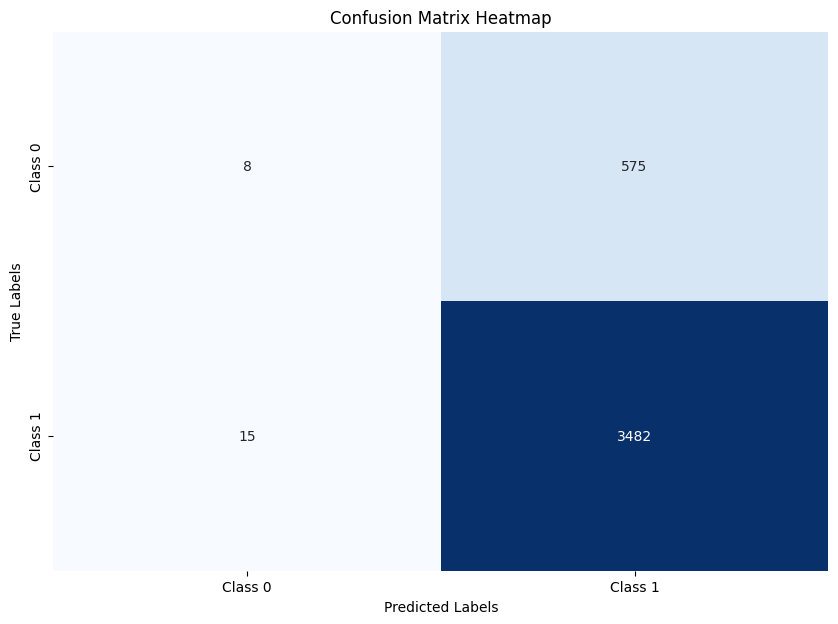

In [66]:
report = classification_report(y_valid_dropped, y_valid_pred, output_dict=True)

precision = {class_name: report[class_name]['precision'] for class_name in report if class_name != 'accuracy'}
recall = {class_name: report[class_name]['recall'] for class_name in report if class_name != 'accuracy'}
f1 = {class_name: report[class_name]['f1-score'] for class_name in report if class_name != 'accuracy'}

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Class 0', 'Class 1'], columns=['Class 0', 'Class 1'])


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [67]:
print("Precision per class:")
for class_name, precision_score in precision.items():
    print(f"{class_name}: {precision_score:.2f}")

print("\nRecall per class:")
for class_name, recall_score in recall.items():
    
    print(f"{class_name}: {recall_score:.2f}")

print("\nF1-Score per class:")
for class_name, f1_score in f1.items():
    print(f"{class_name}: {f1_score:.2f}")


Precision per class:
0: 0.35
1: 0.86
macro avg: 0.60
weighted avg: 0.79

Recall per class:
0: 0.01
1: 1.00
macro avg: 0.50
weighted avg: 0.86

F1-Score per class:
0: 0.03
1: 0.92
macro avg: 0.47
weighted avg: 0.79


In [68]:
from sklearn.metrics import precision_recall_curve

y_probs = clas_xgb.predict_proba(X_valid_clean)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid_dropped, y_probs)
# im using f1 score to tune the threshold since it give balance between precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)

optimal_idx = (f1_scores).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

y_test_pred_optimal = (y_probs >= optimal_threshold).astype(int)


Optimal Threshold: 0.0715116411447525


In [69]:
from sklearn.metrics import f1_score

f1 = f1_score(y_valid_dropped, y_test_pred_optimal, average='macro')

print(f"F1-Score with Tuned Threshold: {f1}")


F1-Score with Tuned Threshold: 0.4615283093572654
